In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
import spacy
from nltk.corpus import stopwords
from collections import Counter
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
#amz = pd.read_csv('ratings_CDs_and_Vinyl.csv')
amz = pd.read_json('reviews_Toys_and_Games_5.json', lines=True)

amz.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0439893577,"[0, 0]",5,I like the item pricing. My granddaughter want...,"01 29, 2014",A1VXOAVRGKGEAK,Angie,Magnetic board,1390953600
1,0439893577,"[1, 1]",4,Love the magnet easel... great for moving to d...,"03 28, 2014",A8R62G708TSCM,Candace,it works pretty good for moving to different a...,1395964800
2,0439893577,"[1, 1]",5,Both sides are magnetic. A real plus when you...,"01 28, 2013",A21KH420DK0ICA,capemaychristy,love this!,1359331200
3,0439893577,"[0, 0]",5,Bought one a few years ago for my daughter and...,"02 8, 2014",AR29QK6HPFYZ4,dcrm,Daughters love it,1391817600
4,0439893577,"[1, 1]",4,I have a stainless steel refrigerator therefor...,"05 5, 2014",ACCH8EOML6FN5,DoyZ,Great to have so he can play with his alphabet...,1399248000


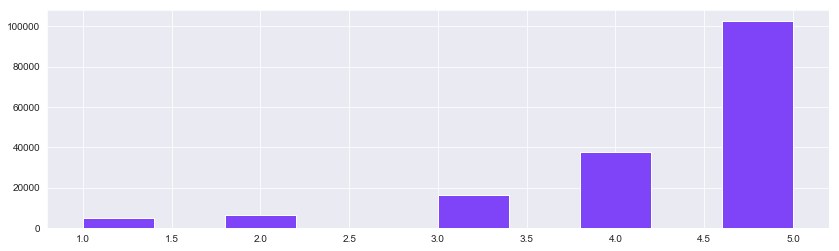

In [3]:
plt.figure(figsize=(14,4))
plt.hist(amz.overall, color='#7F44F7')
plt.show()

Most reviews are 5 star, the least reviews are 1 star

In [4]:
amz.helpful.head()

0    [0, 0]
1    [1, 1]
2    [1, 1]
3    [0, 0]
4    [1, 1]
Name: helpful, dtype: object

In [5]:
helpfuls = amz.helpful.apply(pd.Series)
helpfuls.columns = ['helpful_amt','helpful_tot']
helpfuls['helpful_per'] = helpfuls['helpful_amt']/helpfuls['helpful_tot']
helpfuls['helpful_per']= helpfuls['helpful_per'].fillna(value=0)
helpfuls.head()

,helpful_amt,helpful_tot,helpful_per
0,0,0,0.0
1,1,1,1.0
2,1,1,1.0
3,0,0,0.0
4,1,1,1.0


In [6]:
amz = pd.concat([amz[:], helpfuls[:]], axis=1)

amz.head(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpful_amt,helpful_tot,helpful_per
0,0439893577,"[0, 0]",5,I like the item pricing. My granddaughter want...,"01 29, 2014",A1VXOAVRGKGEAK,Angie,Magnetic board,1390953600,0,0,0.0
1,0439893577,"[1, 1]",4,Love the magnet easel... great for moving to d...,"03 28, 2014",A8R62G708TSCM,Candace,it works pretty good for moving to different a...,1395964800,1,1,1.0


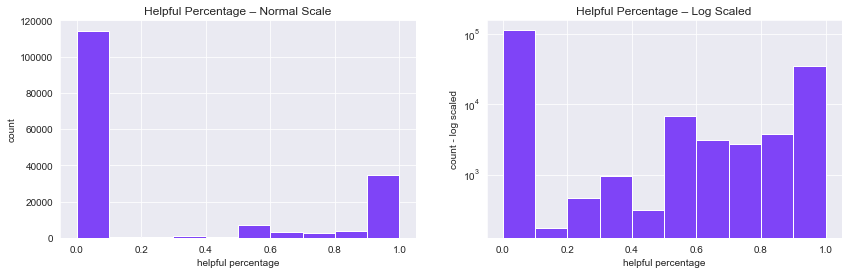

In [7]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.hist(amz.helpful_per, color='#7F44F7')
plt.title('Helpful Percentage – Normal Scale')
plt.ylabel('count')
plt.xlabel('helpful percentage')

plt.subplot(1,2,2)
plt.hist(amz.helpful_per, color='#7F44F7')
plt.yscale('log')
plt.title('Helpful Percentage – Log Scaled')
plt.ylabel('count - log scaled')
plt.xlabel('helpful percentage')
plt.show()

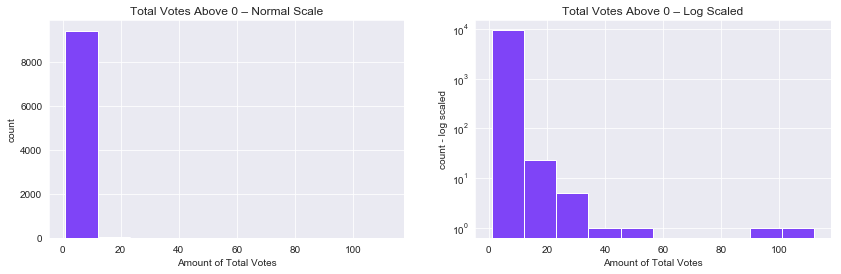

In [8]:
help_z = amz.loc[(amz.helpful_amt == 0)&(amz.helpful_tot>0)]

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.hist(help_z.helpful_tot, color='#7F44F7')
plt.title('Total Votes Above 0 – Normal Scale')
plt.ylabel('count')
plt.xlabel('Amount of Total Votes')

plt.subplot(1,2,2)
plt.hist(help_z.helpful_tot, color='#7F44F7')
plt.yscale('log')
plt.title('Total Votes Above 0 – Log Scaled')
plt.ylabel('count - log scaled')
plt.xlabel('Amount of Total Votes')
plt.show()

#### Insights:
- Most reviews, no one has clicked on if they are helful or not
- Judging by the second most being 100%, I would also venture to say that most reviews have just one vote of if they are helpful or not.
- The third highest percentage being 50% also supports the idea that most do not have that many votes.
- Their being higher percentages in the upper half of the graph, shows that when people do vote, they tend to vote more positively then negatively.

In [9]:
amz.helpful_per.describe()

count    167597.000000
mean          0.275086
std           0.418838
min           0.000000
25%           0.000000
50%           0.000000
75%           0.666667
max           1.000000
Name: helpful_per, dtype: float64

In [12]:
amz['five_star'] = np.where(amz['overall']==5,1,0)
compare = pd.DataFrame()

compare['five'] = amz.five_star.loc[amz.five_star==1].describe()
compare['not'] = amz.five_star.loc[amz.five_star==0].describe()
compare

,five,not
count,102790.0,64807.0
mean,1.0,0.0
std,0.0,0.0
min,1.0,0.0
25%,1.0,0.0
50%,1.0,0.0
75%,1.0,0.0
max,1.0,0.0


Seems like there is a slight imbalance in the data, to get an accurate prediction we'll take 50,000 rows from both the five-star reviews and also the non-five-star reviews

### Balance the Data

In [14]:
amz_s = amz.sample(frac=1, random_state=40)

fivestar = amz_s.loc[amz_s.five_star==1][:50000]
nofive = amz_s.loc[amz_s.five_star==0][:50000]

amz = pd.concat([fivestar, nofive])
amz = amz.sample(frac=1, random_state=40)

compare['five'] = amz.five_star.loc[amz.five_star==1].describe()
compare['not'] = amz.five_star.loc[amz.five_star==0].describe()
compare

,five,not
count,50000.0,50000.0
mean,1.0,0.0
std,0.0,0.0
min,1.0,0.0
25%,1.0,0.0
50%,1.0,0.0
75%,1.0,0.0
max,1.0,0.0


In [15]:
#five_star = text_cleaner(five_star)
amz.reviewText = amz.reviewText.apply(lambda x: re.sub(r'--',' ',x))
amz.reviewText = amz.reviewText.apply(lambda x: re.sub("[\[].*?[\]]", "", x))
amz.reviewText = amz.reviewText.apply(lambda x: ' '.join(x.split()))

In [16]:
# how long it will take and hopefully speed some stuff up
from tqdm import tqdm
tqdm.pandas()

# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en', disable=['ner', 'tagger'])
# add parsed reviews into new column
amz['review_parsed'] = amz.reviewText.progress_apply(nlp)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


100%|██████████| 100000/100000 [22:09<00:00, 75.22it/s] 


In [17]:
# From a sample of 10,000 rows we will find the most common words in 5 star reviews

review_w_1 = ' '.join(amz.review_parsed.loc[amz.overall == 5][0:1000].astype(str))
review_doc_1 = nlp(review_w_1)

review_w_2 = ' '.join(amz.review_parsed.loc[amz.overall == 5][1001:2000].astype(str))
review_doc_2 = nlp(review_w_2)

review_w_3 = ' '.join(amz.review_parsed.loc[amz.overall == 5][2001:3000].astype(str))
review_doc_3 = nlp(review_w_3)

review_w_4 = ' '.join(amz.review_parsed.loc[amz.overall == 5][3001:5000].astype(str))
review_doc_4 = nlp(review_w_4)

review_w_5 = ' '.join(amz.review_parsed.loc[amz.overall == 5][4001:5000].astype(str))
review_doc_5 = nlp(review_w_5)

review_w_6 = ' '.join(amz.review_parsed.loc[amz.overall == 5][5001:6000].astype(str))
review_doc_6 = nlp(review_w_6)

review_w_7 = ' '.join(amz.review_parsed.loc[amz.overall == 5][6001:7000].astype(str))
review_doc_7 = nlp(review_w_7)

review_w_8 = ' '.join(amz.review_parsed.loc[amz.overall == 5][7001:8000].astype(str))
review_doc_8 = nlp(review_w_8)

review_w_9 = ' '.join(amz.review_parsed.loc[amz.overall == 5][8001:9000].astype(str))
review_doc_9 = nlp(review_w_9)

review_w_10 = ' '.join(amz.review_parsed.loc[amz.overall == 5][9001:10000].astype(str))
review_doc_10 = nlp(review_w_10)

In [18]:
amz = amz.drop(columns=['asin','reviewTime', 'reviewerID', 'reviewerName'])

In [27]:
amz = amz.reset_index(drop=True)
amz.head()

,helpful,overall,reviewText,summary,unixReviewTime,helpful_amt,helpful_tot,helpful_per,five_star,review_parsed
0,"[2, 2]",2,My son has a castle that he loves and when his...,Wish I had never purchased,1355961600,2,2,1.0,0,"(My, son, has, a, castle, that, he, loves, and..."
1,"[0, 0]",5,My 18 month old loves this phone! It was a gre...,Great phone!,1068422400,0,0,0.0,1,"(My, 18, month, old, loves, this, phone, !, It..."
2,"[1, 1]",1,I read some reviews complaining about the smel...,The smell is unbearable,1401667200,1,1,1.0,0,"(I, read, some, reviews, complaining, about, t..."
3,"[0, 0]",5,This is my second one of these and it istill g...,nice,1404086400,0,0,0.0,1,"(This, is, my, second, one, of, these, and, it..."
4,"[0, 0]",5,I bought this for my daughter. We never knew w...,pretty neat!,1384214400,0,0,0.0,1,"(I, bought, this, for, my, daughter, ., We, ne..."


In [28]:
# Utility function to create a list of the 200 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(200)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(amz, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = amz['review_parsed']
    df['rating'] = amz['overall']
    df['five_star'] = amz['five_star']
    df['unixReviewTime'] = amz['unixReviewTime']
    df['helpful_amt'] = amz['helpful_amt']
    df['helpful_tot'] = amz['helpful_tot']
    df['helpful_per'] = amz['helpful_per']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 5000 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
#common_words = bag_of_words(review_doc)
#print(common_words)

In [29]:
common_words_1 = bag_of_words(review_doc_1)
common_words_2 = bag_of_words(review_doc_2)
common_words_3 = bag_of_words(review_doc_3)
common_words_4 = bag_of_words(review_doc_4)
common_words_5 = bag_of_words(review_doc_5)
common_words_6 = bag_of_words(review_doc_6)
common_words_7 = bag_of_words(review_doc_7)
common_words_8 = bag_of_words(review_doc_8)
common_words_9 = bag_of_words(review_doc_9)
common_words_10 = bag_of_words(review_doc_10)
common_words = (common_words_1+common_words_2+common_words_1+common_words_3+common_words_4+common_words_5
               +common_words_6+common_words_7+common_words_8+common_words_9+common_words_10)
common_words = list(set(common_words))
print(len(common_words))

287


In [30]:
print(common_words)

['break', 'able', 'baby', 'camera', 'nice', 'use', 'look', 'battery', 'happy', 'tell', 'money', 'friend', '8', 'get', 'read', 'My', 'year', 'child', 'fit', 'As', 'big', 'product', 'etc', 'awesome', 'fly', 'head', 'fact', 'need', 'high', 'pretty', 'Thomas', 'yr', 'definitely', 'push', 'door', 'bite', '5', 'size', 'mean', 'color', 'pack', 'away', 'worth', 'handle', 'know', 'store', 'A', '10', 'animal', 'feature', '1', 'different', 'Christmas', 'let', 'fan', 'picture', 'granddaughter', 'For', 'truck', 'sturdy', 'especially', 'fast', 'food', 'will', 'age', 'hour', 'line', 'helicopter', 'perfect', 'simple', 'educational', 'We', 'fun', 'problem', 'letter', 'But', 'idea', 'hard', 'turn', 'work', 'ask', 'Lego', 'They', 'rule', '2', 'favorite', 'challenge', 'old', 'action', 'like', 'She', 'race', 'one', 'add', 'Doug', 'Very', 'All', 'stick', 'day', 'sure', 'sit', 'have', 'teach', 'blue', '-PRON-', 'light', 'The', 'And', 'original', 'book', 'purchase', 'play', 'house', 'shape', 'paint', 'button'

In [31]:
word_counts = bow_features(amz, common_words)
word_counts.head()

Processing row 0
Processing row 5000
Processing row 10000
Processing row 15000
Processing row 20000
Processing row 25000
Processing row 30000
Processing row 35000
Processing row 40000
Processing row 45000
Processing row 50000
Processing row 55000
Processing row 60000
Processing row 65000
Processing row 70000
Processing row 75000
Processing row 80000
Processing row 85000
Processing row 90000
Processing row 95000


,break,able,baby,camera,nice,use,look,battery,happy,tell,...,board,rotate,I,text_sentence,rating,five_star,unixReviewTime,helpful_amt,helpful_tot,helpful_per
0,1,0,0,0,0,0,0,0,0,0,...,0,0,4,"(My, son, has, a, castle, that, he, loves, and...",2,0,1355961600,2,2,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,"(My, 18, month, old, loves, this, phone, !, It...",5,1,1068422400,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,"(I, read, some, reviews, complaining, about, t...",1,0,1401667200,1,1,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,"(This, is, my, second, one, of, these, and, it...",5,1,1404086400,0,0,0.0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,"(I, bought, this, for, my, daughter, ., We, ne...",5,1,1384214400,0,0,0.0


In [33]:
from sklearn.feature_selection import SelectKBest, f_classif

X = word_counts.drop(['five_star','rating','text_sentence'], 1)
y = word_counts['five_star']

selector=SelectKBest(score_func=f_classif,k=291)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

scores.loc[scores['P Value']<.05]

,Attribute,F Score,P Value,Support
194,not,4290.780990,0.000000e+00,True
220,love,1959.389292,0.000000e+00,True
286,I,1821.516303,0.000000e+00,True
89,like,1742.886697,0.000000e+00,True
106,The,1658.045719,0.000000e+00,True
219,think,1613.765448,0.000000e+00,True
202,star,1272.012461,7.587822e-277,True
197,try,1125.331661,2.401164e-245,True
75,But,1086.560112,5.187746e-237,True
79,work,1072.411814,5.717971e-234,True


In [71]:
# key_vals = scores.Attribute.head(80).values

key_vals = scores.Attribute.loc[scores['P Value']<.05].values

X = word_counts[key_vals]
y = word_counts['five_star']

## Modeling

In [72]:
# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Logistic Regression

In [37]:
from sklearn.metrics import roc_auc_score

# How long will it take
from datetime import datetime
start_time = datetime.now()

# get rid of the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e9, max_iter = 150)
lr.fit(x_train, y_train)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

print('Train Percentage accuracy:')
print(lr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(lr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(lr, x_train, y_train, cv = 5))

auc = roc_auc_score(y_test, ypred_lr)
print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Train Percentage accuracy:
0.5001866666666667

Test Percentage accuracy:
0.49944

Cross Validation:
[0.50016666 0.5002     0.5002     0.5002     0.50016668]

Area Under Curve:
AUC: 0.500

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12514
           1       0.50      1.00      0.67     12486

   micro avg       0.50      0.50      0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000


Duration: 0:00:02.997325


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
start_time = datetime.now()
# get rid of the warnings
import warnings
warnings.filterwarnings("ignore")

# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'C':[1e9,.5,1,3], 'max_iter':[25,50,100], 'penalty':['l1','l2']}

# Start the grid search again
grid_DT = GridSearchCV(lr, param_grid, cv=3, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:')
print(grid_DT.best_params_)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 41.7min finished


Best score for data:
{'C': 1000000000.0, 'max_iter': 50, 'penalty': 'l1'}

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12514
           1       0.50      1.00      0.67     12486

   micro avg       0.50      0.50      0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000


Duration: 0:44:48.785196


#### Insights
- Logistic regression runs pretty poorly here. With almost no ability to predict anything other than the outcome variable and even then not very well.
- I think the strictly binary nature of logistic regression is holding this model back a bit. With the data having a text focus, other models may be better equipped to predict on this data set.

### Naive Bayes

In [42]:
start_time = datetime.now()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
# Set Up Predictor
ypred_bnb = bnb.predict(x_test)

print('\nTrain Percentage accuracy:')
print(bnb.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(bnb.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(bnb, x_train, y_train, cv = 5))

print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_bnb))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6309866666666667

Test Percentage accuracy:
0.63052

Cross Validation:
[0.63522432 0.6282     0.631      0.6276     0.63044203]

Area Under Curve:
AUC: 0.500

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.53      0.59     12514
           1       0.61      0.73      0.66     12486

   micro avg       0.63      0.63      0.63     25000
   macro avg       0.64      0.63      0.63     25000
weighted avg       0.64      0.63      0.63     25000


Duration: 0:00:03.053461


#### Insights
- Like I pointed out above with the logistic regression, a non-numerical focused model might work better on the data and sure enough naive bayes most certainly does.
- While this does work better on the data, it has a lot of room for improvement. The precision for both variables is alright but the recall on the false outcomes is a bit worrying.

### K Nearest Neighbors

In [43]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6060266666666667

Test Percentage accuracy:
0.56452

Cross Validation:
[0.56489567 0.5604     0.5582     0.55793333 0.55083672]

Area Under Curve:
AUC: 0.500

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.46      0.51     12514
           1       0.55      0.67      0.61     12486

   micro avg       0.56      0.56      0.56     25000
   macro avg       0.57      0.56      0.56     25000
weighted avg       0.57      0.56      0.56     25000


Duration: 0:00:29.342848


In [66]:
start_time = datetime.now()
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_neighbors':[15,30,50,100,150,300,500,750,1000]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=3, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:')
print(grid_DT.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best score for data:
{'n_neighbors': 500}


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   54.0s finished


In [67]:
start_time = datetime.now()

knn = neighbors.KNeighborsClassifier(n_neighbors=500)
knn.fit(x_train, y_train)

# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.60756

Test Percentage accuracy:
0.60576

Cross Validation:
[0.61202586 0.6026     0.6062     0.60086667 0.60757384]

Area Under Curve:
AUC: 0.500

Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.63      0.62     12514
           1       0.61      0.58      0.60     12486

   micro avg       0.61      0.61      0.61     25000
   macro avg       0.61      0.61      0.61     25000
weighted avg       0.61      0.61      0.61     25000


Duration: 0:00:26.728532


#### Insights
- KNN doesn't seem to really improve on Naive Bayes. It might be because of the generally large amount of features.
- Running grid search CV and ultimately upping the amount of neighbors by a considerably amount helped reduce the amount of overfitting in the data.
- All in all, after upping the amount of neighbors this model actually runs pretty well. The accuracy score isn't perfect but it runs very balanced without much overfitting. 

### Decision Tree

In [44]:
start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=20,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_dec_tr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6025866666666667

Test Percentage accuracy:
0.5848

Cross Validation:
[0.58416106 0.576      0.5834     0.58533333 0.57957197]

Area Under Curve:
AUC: 0.500

Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.57      0.58     12514
           1       0.58      0.60      0.59     12486

   micro avg       0.58      0.58      0.58     25000
   macro avg       0.58      0.58      0.58     25000
weighted avg       0.58      0.58      0.58     25000


Duration: 0:00:01.711542


#### Insights
- Similar to other models, the decision tree runs alright. With not quite the best score we've had so far but a pretty good balance between precision and recall on both outcomes.
- In true form with decision trees, this model is showing a bit of overfitting on the data and I can only imagine it might get worse if run on a larger dataset of reviews

### Gradient Boosted Decision Tree

In [73]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='exponential', max_depth=10 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.79724

Test Percentage accuracy:
0.70364

Cross Validation:
[0.70501967 0.70533333 0.69853333 0.70286667 0.69831322]

Area Under Curve:
AUC: 0.500

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70     12514
           1       0.70      0.71      0.70     12486

   micro avg       0.70      0.70      0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000


Duration: 0:53:43.909040


#### Insights
- While this is our best performing model by far so far, using it in a production environment might be a bit of a risk given it looks like it is overfitting a slight bit.
- The overfitting is unfortunate, as the scores are quite good. With a great balance between precision and recall scores. 
- The general performance of this model isn't ideal as well. Where a runtime of about 50 minutes isn't the worst possible outcome, it also isn't ideal.

### Random Forest

In [46]:
start_time = datetime.now()
rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6861866666666666

Test Percentage accuracy:
0.67524

Cross Validation:
[0.67748817 0.67373333 0.6774     0.67466667 0.67224482]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67     12514
           1       0.67      0.69      0.68     12486

   micro avg       0.68      0.68      0.68     25000
   macro avg       0.68      0.68      0.68     25000
weighted avg       0.68      0.68      0.68     25000


Duration: 0:00:14.938187


#### Insights
- This is probably our best performing model so far. Achieving a nearly 70% accuracy with very little signs of overfitting. 
- Random Forest seems like a pretty good option for this set of data. It has all of the benefits found on the decision tree but seems to fix the overfitting problem we were having.
- The precision and recall scores for both outcomes here are fairly even and would perform reasonably well in a production environment.

### PCA with Bayes, Gradient Boosted Decision Tree & Random Forest

In [49]:
from sklearn.preprocessing import StandardScaler

# Separating out the features
X = word_counts[key_vals].values
# Separating out the target
y = word_counts['five_star'].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1','pc2','pc3'])

In [64]:
amz_pc = pd.concat([principalDf, word_counts], axis = 1).dropna().reset_index(drop=True)

In [53]:
# Separating out the features
X = amz_pc[['pc1','pc2','pc3']]
# Separating out the target
y = amz_pc['five_star']

In [54]:
# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Naive Bayes

In [55]:
start_time = datetime.now()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
# Set Up Predictor
ypred_bnb = bnb.predict(x_test)

print('\nTrain Percentage accuracy:')
print(bnb.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(bnb.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(bnb, x_train, y_train, cv = 5))

print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_bnb))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5767066666666667

Test Percentage accuracy:
0.57788

Cross Validation:
[0.57662822 0.57426667 0.57586667 0.57526667 0.58150543]

Area Under Curve:
AUC: 0.500

Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.53      0.56     12514
           1       0.57      0.63      0.60     12486

   micro avg       0.58      0.58      0.58     25000
   macro avg       0.58      0.58      0.58     25000
weighted avg       0.58      0.58      0.58     25000


Duration: 0:00:00.180982


### Decision Tree

In [56]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='exponential', max_depth=8 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6444133333333333

Test Percentage accuracy:
0.60408

Cross Validation:
[0.60789281 0.6002     0.6058     0.59973333 0.60244016]

Area Under Curve:
AUC: 0.500

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61     12514
           1       0.61      0.59      0.60     12486

   micro avg       0.60      0.60      0.60     25000
   macro avg       0.60      0.60      0.60     25000
weighted avg       0.60      0.60      0.60     25000


Duration: 0:00:31.930119


### Random Forest

In [57]:
start_time = datetime.now()
rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.61892

Test Percentage accuracy:
0.60464

Cross Validation:
[0.61049263 0.6016     0.60686667 0.60266667 0.60337356]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61     12514
           1       0.61      0.58      0.59     12486

   micro avg       0.60      0.60      0.60     25000
   macro avg       0.60      0.60      0.60     25000
weighted avg       0.60      0.60      0.60     25000


Duration: 0:00:12.557639


### Decision Tree

In [58]:
start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=20,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_dec_tr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.70912

Test Percentage accuracy:
0.57836

Cross Validation:
[0.57922805 0.57393333 0.57026667 0.57033333 0.57563838]

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.60      0.59     12514
           1       0.58      0.56      0.57     12486

   micro avg       0.58      0.58      0.58     25000
   macro avg       0.58      0.58      0.58     25000
weighted avg       0.58      0.58      0.58     25000


Duration: 0:00:01.175464


In [59]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6296533333333333

Test Percentage accuracy:
0.5902

Cross Validation:
[0.59089394 0.58966667 0.58466667 0.58726667 0.5910394 ]

Area Under Curve:
AUC: 0.500

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.64      0.61     12514
           1       0.60      0.54      0.57     12486

   micro avg       0.59      0.59      0.59     25000
   macro avg       0.59      0.59      0.59     25000
weighted avg       0.59      0.59      0.59     25000


Duration: 0:00:02.451482


In [62]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_neighbors':[5,10,30,50,75,100,150,300,500,700,1000]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=5, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score for data: {'n_neighbors': 700}


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  4.8min finished


In [63]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=700)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6072

Test Percentage accuracy:
0.6052

Cross Validation:
[0.61282581 0.6034     0.60646667 0.60046667 0.60677378]

Area Under Curve:
AUC: 0.500

Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.63      0.62     12514
           1       0.61      0.58      0.59     12486

   micro avg       0.61      0.61      0.61     25000
   macro avg       0.61      0.61      0.60     25000
weighted avg       0.61      0.61      0.60     25000


Duration: 0:00:34.945774


## Conclusion
Running PCA through all of the models helped speed up performance generally on just about all models but with the cost of some performance on just about all of them as well. I would only recommend going with the PCA'd versions if performance was a real issue. It specifically seemed to help a bout of overfitting on the KNN model but otherwise the benefits seemed to be only in the performance.

After running all of the models, it is clear that Random Forest is the clear choice for moving forward into production with. It's reliance on the decision based features of the decision tree gives it all the benefits of the decision tree without the overfitting issues. It seems to play very well with the text based nature of the dataset or at least the binary nature of almost all of the features.